<a href="https://colab.research.google.com/github/palswayam5/AI_generated_Images_Classifier/blob/master/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tf-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.0/441.0 kB 24.2 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense,LayerNormalization,Dropout,Add,Embedding,MultiHeadAttention,Input,Flatten
from tensorflow.keras import Model
from tensorflow.image import extract_patches
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import keras.backend as K
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow import keras

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Dataset/test.csv')

In [4]:
df.head()

,labels,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_1190,f_1191,f_1192,f_1193,f_1194,f_1195,f_1196,f_1197,f_1198,f_1199
0,0,-2.033875,0.978446,-0.142131,-0.177117,-1.470684,1.669562,-0.196530,-0.125239,-0.452284,...,-1.111266,0.716084,0.060039,0.301279,-1.174846,-1.076498,-0.069452,-0.604012,-2.179176,0.558003
1,1,-0.348835,0.294815,-0.557577,-2.020773,-1.234715,1.633930,-1.680658,-0.358146,0.166122,...,0.735240,0.829781,1.521941,1.347946,0.754505,1.330642,-0.754453,0.582956,0.252671,1.495870
2,1,0.113248,-0.607726,-0.947791,0.830851,0.998291,0.498321,-1.493958,0.789572,-1.311018,...,0.104698,0.616189,-1.035953,2.111387,-0.984415,1.148076,-1.433554,0.243372,0.170083,1.274795
3,0,1.223321,-0.479048,-1.925789,1.680377,0.021840,-1.453307,0.605559,-0.019024,1.065448,...,0.360237,-1.957863,-0.123384,1.505329,0.660290,-1.769443,-0.547756,-0.568122,0.244645,0.982116
4,0,0.160109,0.422684,-0.308029,0.227744,0.432854,0.608348,0.193832,1.035091,-0.538868,...,0.416629,1.441766,0.212572,-0.994721,1.143999,-2.166923,-1.199248,-1.028636,0.752791,0.317169


In [5]:
X = df.drop('labels',axis = 1).to_numpy()
y = df['labels'].to_numpy()
X = X.reshape(-1,20,20,3)
y = y.reshape(-1,1)

In [49]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.5,shuffle = True)

In [50]:
def count(y):
  n = len(y)
  count_0 = 0
  count_1 = 1
  for i in range(n):
    if(y[i]==0):
      count_0+=1
    else:
      count_1+=1
  return (count_0,count_1)

In [51]:
print("(0's,1's) in y :",count(y))
print("(0's,1's) in y_train :",count(y_train))
print("(0's,1's) in y_val :",count(y_val))

(0's,1's) in y : (3850, 1401)
(0's,1's) in y_train : (1907, 719)
(0's,1's) in y_val : (1943, 683)


In [52]:
print(X_train.shape,y_train.shape,X_val.shape,y_val.shape)

(2625, 20, 20, 3) (2625, 1) (2625, 20, 20, 3) (2625, 1)


Variables

In [8]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [30]:
num_layers = 6 #repeating layers in a vision transformer
num_epochs = 50
input_shape = (20,20,3)
patch_size = 4
final_hidden_units = [2048,1024];
dropout = 0.3
head = 4
dim = 64
num_patches = (input_shape[0]//patch_size)**2 # here 25
num_classes = 2
transformer_units = [dim * 2,dim]
image_size = 20

Multi Layer Perceptron

In [10]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

In [31]:
def mlp(x,hidden_units,dropout_rate):   #multi_layer_perceptron
   for units in hidden_units:
    x =  Dense(units = units)(x)
    x = Dropout(dropout_rate)(x)
   return x

In [32]:
def create_patches(image):
  batch_size = tf.shape(image)[0]
  patches = extract_patches(
      images = image,
      sizes = [1,patch_size,patch_size,1],
      strides = [1,patch_size,patch_size,1],
      padding = "VALID",
      rates = [1,1,1,1],
  )
  patch_dims = patches.shape[-1]
  patches = tf.reshape(patches, [batch_size, -1, patch_dims])
  return patches

In [33]:
def encode_patches(patches):
  positions = tf.range(start=0, limit=num_patches, delta=1)
  patches = Dense(units = dim)(patches)
  positions = Embedding(input_dim = num_patches,output_dim = dim)(positions)
  encoded_patches = patches+positions
  return encoded_patches

In [34]:
def vit_classifier():
  input = Input(shape = input_shape)
  #augmented_data = data_augmentation(input)
  patches = create_patches(input)
  encoded_patches = encode_patches(patches)

  for i in range(num_layers):
    x = LayerNormalization(epsilon = 1e-6)(encoded_patches)
    x1 = MultiHeadAttention(num_heads = head,key_dim = dim,dropout = dropout)(x,x)
    x2 = Add()([x1,encoded_patches])
    x2 = LayerNormalization(epsilon = 1e-6)(x2)
    x3 = mlp(x2,transformer_units,dropout)
    encoded_patches = Add()([x3,x2])
  x = LayerNormalization(epsilon = 1e-6)(encoded_patches)
  x = Flatten()(x)
  x = Dropout(dropout)(x)
  x = mlp(x,final_hidden_units,dropout)
  y = Dense(units = num_classes,activation = "softmax")(x)
  model = Model(inputs = input,outputs = y)
  return model


In [53]:
model = vit_classifier()

In [54]:
model.compile(optimizer = 'Adadelta',loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])

In [55]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [56]:
history = model.fit(X_train,y_train,validation_data = (X_val,y_val),epochs = num_epochs,callbacks = [stop_early])

Epoch 1/50
83/83 [==============================] - 22s 69ms/step - loss: 1.5886 - accuracy: 0.5150 - val_loss: 0.8118 - val_accuracy: 0.6282
Epoch 2/50
83/83 [==============================] - 4s 47ms/step - loss: 1.4015 - accuracy: 0.5330 - val_loss: 0.7313 - val_accuracy: 0.6583
Epoch 3/50
83/83 [==============================] - 3s 42ms/step - loss: 1.3016 - accuracy: 0.5813 - val_loss: 0.7020 - val_accuracy: 0.6728
Epoch 4/50
83/83 [==============================] - 3s 41ms/step - loss: 1.3239 - accuracy: 0.5608 - val_loss: 0.6846 - val_accuracy: 0.6869
Epoch 5/50
83/83 [==============================] - 5s 55ms/step - loss: 1.3097 - accuracy: 0.5669 - val_loss: 0.6731 - val_accuracy: 0.6990
Epoch 6/50
83/83 [==============================] - 4s 52ms/step - loss: 1.2507 - accuracy: 0.5989 - val_loss: 0.6619 - val_accuracy: 0.7063
Epoch 7/50
83/83 [==============================] - 4s 48ms/step - loss: 1.2022 - accuracy: 0.6046 - val_loss: 0.6563 - val_accuracy: 0.7116
Epoch 8/50
8

In [57]:
y_val_predict = model.predict(X_val)
y_val_predict

83/83 [==============================] - 2s 10ms/step


array([[2.70158947e-01, 7.29841053e-01],
       [9.99999881e-01, 1.17071856e-07],
       [9.02768672e-01, 9.72312465e-02],
       ...,
       [5.83815351e-02, 9.41618502e-01],
       [3.48419100e-01, 6.51580930e-01],
       [2.57718457e-05, 9.99974251e-01]], dtype=float32)

In [58]:
y_val_fa = np.zeros([len(y_val_predict)])
for i in range(len(y_val_predict)):
  if(y_val_predict[i][0]>y_val_predict[i][1]):
    y_val_fa[i] = 0
  else:
    y_val_fa[i] = 1
y_val_fa


array([1., 0., 0., ..., 1., 1., 1.])

In [59]:
y_val_fa = y_val_fa.reshape(-1,1)
f1_score(y_val,y_val_fa)

0.5963369963369963

In [60]:
df_test.head()

,id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_1190,f_1191,f_1192,f_1193,f_1194,f_1195,f_1196,f_1197,f_1198,f_1199
0,1,-3.388242,0.868285,-0.427619,-0.678964,-1.625735,0.262761,1.243040,1.537751,-0.352028,...,-0.776403,-0.662884,-0.257091,-1.168413,0.223260,-0.482520,-0.085453,-0.382265,-0.539349,-1.682404
1,2,-0.496920,0.952381,0.989040,0.451422,0.513516,-0.099658,-1.124326,0.729430,-0.216224,...,0.379635,-1.760084,1.125450,-0.328047,-0.880305,-1.257607,0.964312,2.021104,0.655021,-0.423029
2,3,1.128369,-0.537951,2.544358,1.165254,-1.904994,0.776961,-0.495768,0.060111,-1.418468,...,1.165254,-1.373589,-0.483701,-0.964782,-0.869555,0.066040,-0.444567,-0.531935,-0.878660,1.099488
3,4,0.051253,1.746814,0.681177,1.844524,-0.327977,1.226839,-0.085519,0.379008,-1.003667,...,-0.442288,-2.794472,-0.763468,-0.789832,-0.113209,-2.703150,-2.058728,1.070627,-0.458045,-0.435825
4,5,1.423209,-0.983594,-1.694170,1.197507,1.044211,0.518777,-0.298612,-0.365174,0.738447,...,-2.624450,-3.200223,0.711422,-0.190394,0.337224,-1.656639,0.707360,-0.562290,1.471181,-0.192000


In [61]:
X_test = df_test.drop('id',axis = 1).to_numpy()
id = df_test['id'].to_numpy()
X_test = X_test.reshape(-1,20,20,3)

In [62]:
y_test = model.predict(X_test)
y_fa = np.zeros([len(y_test)])
for i in range(len(y_test)):
  if(y_test[i][0]>y_test[i][1]):
    y_fa[i] = 0
  else:
    y_fa[i] = 1
y_fa

71/71 [==============================] - 1s 10ms/step


array([1., 0., 0., ..., 1., 0., 0.])

In [63]:
y_fa.shape

(2250,)

In [64]:
id = id.reshape(-1,1)
y_fa = y_fa.reshape(-1,1)
print(id.shape,y_fa.shape)

(2250, 1) (2250, 1)


In [65]:
temp = np.concatenate([id,y_fa],axis = 1)
temp.shape

(2250, 2)

In [66]:
submission = pd.DataFrame(temp,columns = ['id','labels'])

In [67]:
submission.to_csv('vit.csv')

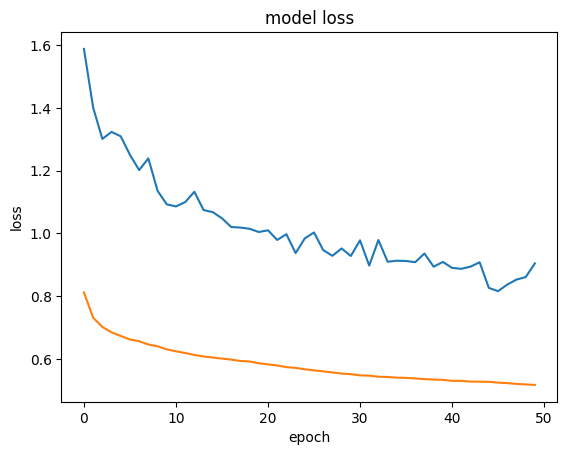

In [68]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()